# Imports

In [13]:
import dictdiffer
import itertools
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pathlib
import pprint
import seaborn as sns
import scipy.special as sp
import sys

from collections import defaultdict
from typing import *
from google.protobuf.json_format import MessageToDict

# (disable?) label latex support for matplotlib
plt.rcParams['text.usetex'] = False

# import protobuf module.
a_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'python_generated'))
sys.path.insert(0, a_path)
import message_pb2 as pb

# Load data

In [2]:
RESULTS_DIRECTORY = pathlib.Path('../../data/no-drug-homogeneous-phase-transition/')
experiments: List[pb.Experiment] = []
# Read the existing address book.
for protobuf_file in RESULTS_DIRECTORY.glob('*.pb'):
  with protobuf_file.open('rb') as f:
    experiment = pb.Experiment()
    experiment.ParseFromString(f.read())
    experiments.append(experiment)

# Data check

In [3]:
control_experiment = experiments[0]
# Note that homogeneously distributed networks have type 0.
assert control_experiment.experiment_config.network_config.out_degree_distribution_type == 0, "network should be homogeneous"
assert all(
  experiment.experiment_config.dynamics_config == control_experiment.experiment_config.dynamics_config
  for experiment in experiments
), "dynamics config differs"
assert all(
  experiment.experiment_config.drug_config == control_experiment.experiment_config.drug_config
  for experiment in experiments
), "drug config differs"
assert all(
  experiment.experiment_config.network_config.network_size == control_experiment.experiment_config.network_config.network_size
  for experiment in experiments
), "network size differs"
assert all(
  experiment.experiment_config.network_config.out_degree_distribution_type == control_experiment.experiment_config.network_config.out_degree_distribution_type
  for experiment in experiments
), "not all networks are homogeneously distributed"
control_experiment.experiment_config

num_networks: 100
dynamics_config {
  num_steps: 30
  num_initial_conditions: 20
}
network_config {
  network_size: 500
  expected_connectivity: 2.5
  poisson_out_degree_distribution {
    lambda: 2.5
  }
}
drug_config {
}

# Format data

In [4]:
# (experiment, network, initial_condition, time/step, node_idx)
A = (
  np.array([
    np.array([
      np.array([
        np.array([
          np.array(state.state)
          for state in trajectory.states
        ])
        for trajectory in result.perturbations[0].trajectories
      ])
      for result in experiment.results
    ])
    for experiment in experiments
  ])
)

assert A.shape == (
  len(experiments),
  control_experiment.experiment_config.num_networks,
  control_experiment.experiment_config.dynamics_config.num_initial_conditions,
  control_experiment.experiment_config.dynamics_config.num_steps+1,
  control_experiment.experiment_config.network_config.network_size,
), A.shape

# Compute hamming distances

In [19]:
def compute_hamming_distance(x, y):
  return (x ^ y).mean()

def compute_mutual_information(B):
  joint_counts = [
    Counter(
      (B[initial_condition_idx_1, node_idx], B[initial_condition_idx_2, node_idx])
      for initial_condition_idx_1 in range(experiment.experiment_config.dynamics_config.num_initial_conditions)
      for initial_condition_idx_2 in range(initial_condition_idx_1+1, experiment.experiment_config.dynamics_config.num_initial_conditions)
    )
    for node_idx in range(experiment.experiment_config.network_config.network_size)
  ]

  joint_probs = [
    {
      (x, y): count / joint_count.total()
      for (x, y), count in joint_count.items()
    }
    for joint_count in joint_counts
  ]

  pss = [
    (lambda x, y:
      joint_prob.get((x, y), 0) if None not in [x, y] else
      joint_prob.get((x, False), 0) + joint_prob.get((x, True), 0) if x is not None and y is None else
      joint_prob.get((False, y), 0) + joint_prob.get((True, y), 0) if x is None and y is not None else
      1
    )
    for joint_prob in joint_probs
  ]
  mutual_infos = [
    sum(
      ps(x, y) * np.log(ps(x, y)/(ps(x, None) * ps(None, y)))
      for (x, y) in itertools.repeat([False, True], times=2)
      if all(p > 0 for p in (ps(x, y), ps(x, None), ps(None, y)))
    )
    for ps in pss
  ]

  return mutual_infos

In [ ]:
last_step = experiment.experiment_config.dynamics_config.num_steps
steady_state_hamming_distance_data = [
  (
    experiment.experiment_config.network_config.expected_connectivity,
    compute_hamming_distance(
      x:=A[experiment_idx,network_idx,initial_condition_idx_1,last_step],
      y:=A[experiment_idx,network_idx,initial_condition_idx_2,last_step],
    ),
  )
  for experiment_idx, experiment in enumerate(experiments)
  for network_idx in range(experiment.experiment_config.num_networks)
  for initial_condition_idx_1 in range(experiment.experiment_config.dynamics_config.num_initial_conditions)
  for initial_condition_idx_2 in range(initial_condition_idx_1+1, experiment.experiment_config.dynamics_config.num_initial_conditions)
]

steady_state_hamming_distance_df = pd.DataFrame(steady_state_hamming_distance_data, columns=['K', 'hamming_distance'])

In [20]:
last_step = experiment.experiment_config.dynamics_config.num_steps
steady_state_mutual_information_data = [
  (
    experiment.experiment_config.network_config.expected_connectivity,
    mutual_information,
  )
  for experiment_idx, experiment in enumerate(experiments)
  for network_idx in range(experiment.experiment_config.num_networks)
  for node_idx, mutual_information in enumerate(compute_mutual_information(A[experiment_idx,network_idx,:,last_step]))
]

steady_state_mutual_information_df = pd.DataFrame(steady_state_mutual_information_data, columns=['K', 'mutual_information'])

# Plot steady state hamming distance vs K

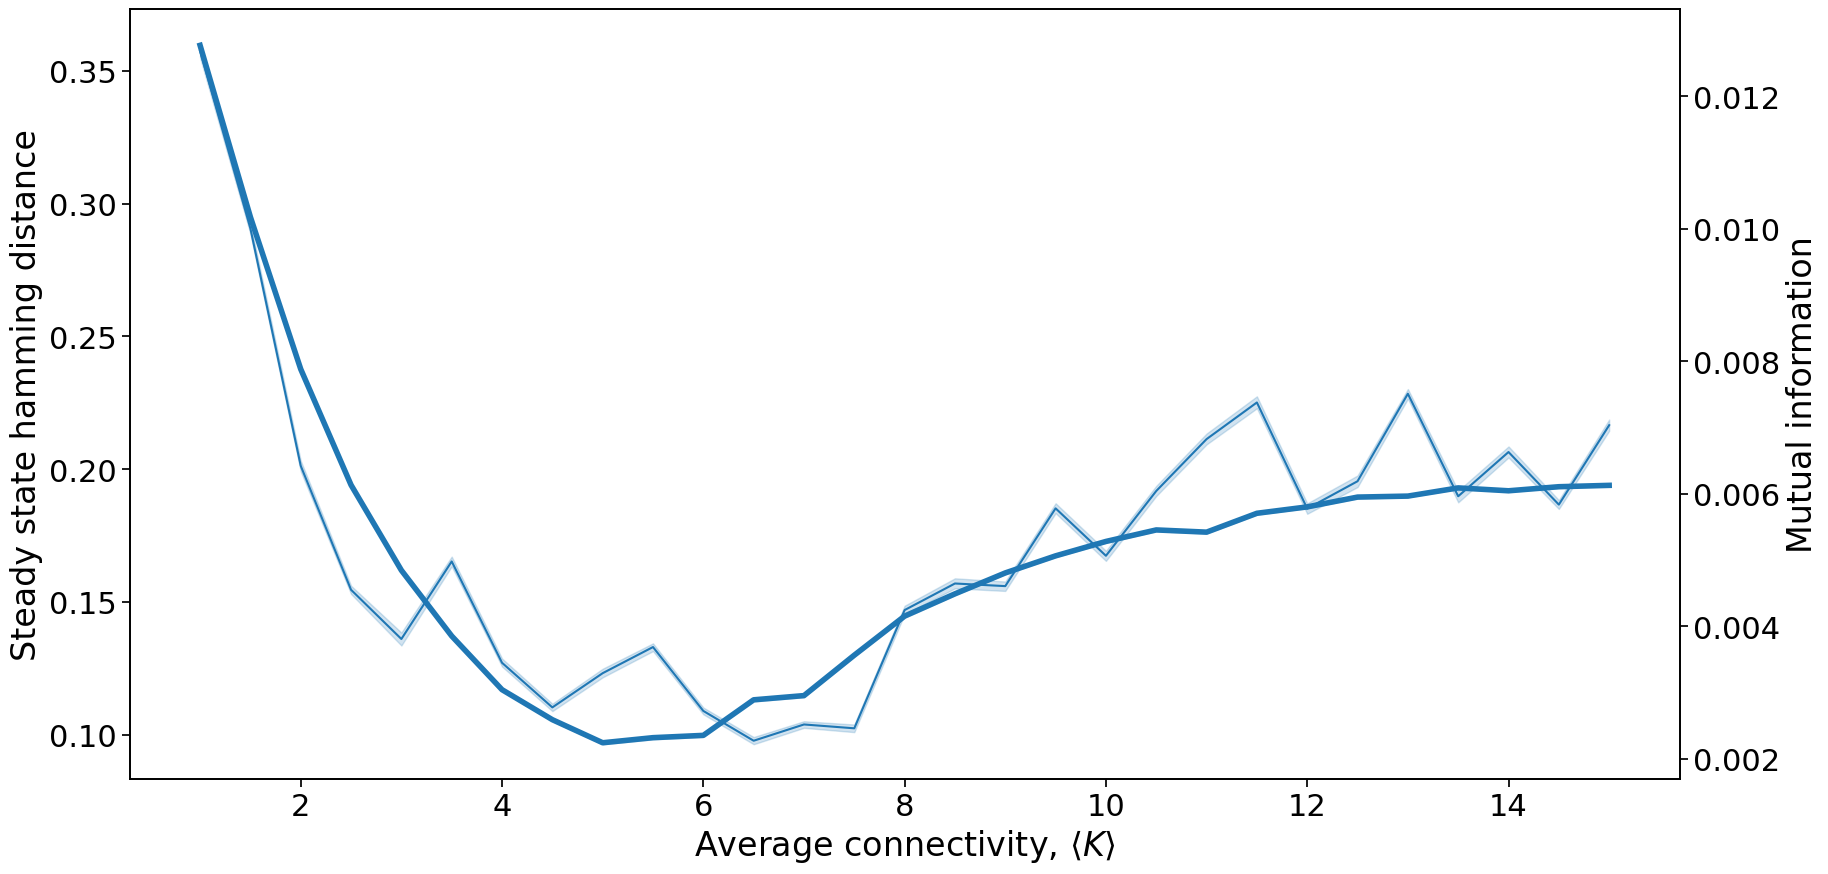

In [21]:
plt.figure(figsize=(20, 10))
with sns.plotting_context('notebook', font_scale=2.0):
  g = sns.lineplot(
    data=steady_state_hamming_distance_df,
    x='K',
    y='hamming_distance',
    lw=4,
    legend=False,
  )
  g.set(xlabel='Average connectivity, $\\langle K \\rangle$', ylabel='Steady state hamming distance')
  
  ax2 = plt.twinx()
  h = sns.lineplot(
    data=steady_state_mutual_information_df,
    x='K',
    y='mutual_information',
    ax=ax2,
  )
  h.set(ylabel='Mutual information')